In [ ]:
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Add the path to the custom library to the system path
sys.path.append('..')

# Import the module from the custom library
from src import utils
from src import Model
from src import layers
from src import metrics
from src import callbacks
from src import optimizers
from src import activations
from src import loss_functions

### Constants and hyperparameters

In [2]:
train_test_split_pct = 0.1 # Percentage of samples to use for testing
train_valid_split = 0.1 # Percentage of samples to use for validation
learning_rate = 1e-4 # Learning rate for the optimizer
batch_size = 128 # Number of samples to use for each batch
epochs = 50 # Number of epochs to train the model
seed = 1234 # Seed for reproducibility

In [3]:
# Set the seed for reproducibility
np.random.seed(seed)

### Data loading

In [4]:
# Load the dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() # type: ignore

# Add a channel dimension to the images
X_train = np.expand_dims(X_train, axis=-1) # type: ignore
X_test = np.expand_dims(X_test, axis=-1) # type: ignore

# Extract the number of classes in the dataset
num_classes = len(np.unique(y_train)) # type: ignore

# Split the training set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=train_valid_split, random_state=seed) # type: ignore

# Print the dataset information
print("Number of classes:", num_classes)
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_valid.shape, y_valid.shape)
print('Testing set:', X_test.shape, y_test.shape)

Number of classes: 10
Training set: (54000, 28, 28, 1) (54000,)
Validation set: (6000, 28, 28, 1) (6000,)
Testing set: (10000, 28, 28, 1) (10000,)


### Data preprocessing

In [5]:
# Normalization
def normalize(X: np.ndarray) -> np.ndarray:
    """
    Normalize the input data by dividing by the maximum value in the training set.
    
    Parameters:
    - X (np.ndarray): The input data to normalize
    
    Returns:
    - np.ndarray: The normalized input data
    """
    
    # Normalize the input data
    return X / 255.0

# Normalize the input data
X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)

In [6]:
# Convert the target values to one-hot encoded vectors
y_train_encoded = utils.one_hot_encoding(y=y_train, n_classes=num_classes)
y_valid_encoded = utils.one_hot_encoding(y=y_valid, n_classes=num_classes)

# Print one sample encoding
print("Sample target value:", y_train[0])
print("One-hot encoded value:", y_valid_encoded[0])

Sample target value: 8
One-hot encoded value: [0 0 0 0 0 1 0 0 0 0]


### Data visualization

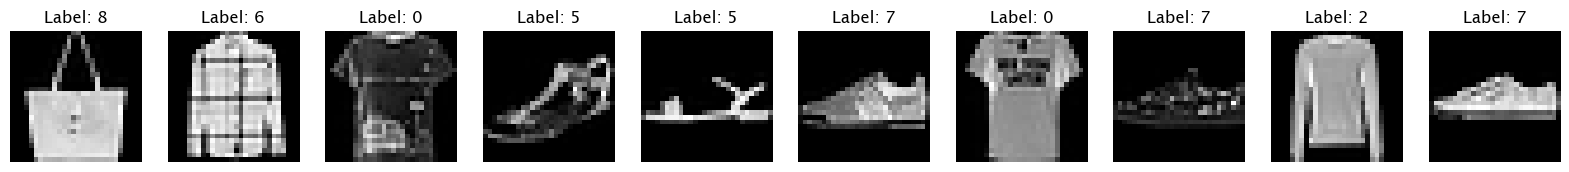

In [7]:
def plot_samples(samples: list[np.ndarray], labels: list[np.ndarray]) -> None:
    """
    Plot the samples in a grid.
    
    Parameters:
    - samples (list[np.ndarray]): The samples to plot
    - labels (list[np.ndarray]): The labels of the samples
    """
        
    # Plot the samples in a grid
    fig, axes = plt.subplots(1, len(samples), figsize=(20, 5))
    for i, ax in enumerate(axes):
        ax.imshow(samples[i], cmap='gray')
        ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')
        
# Plot the first 10 samples
plot_samples(list(X_train[:10]), y_train[:10])

### Building the model

In [ ]:

model = Model([
    layers.Conv2D(num_filters=32, kernel_size=(3, 3), activation=activations.ReLU(), padding='same'),
    layers.MaxPool2D(size=(2, 2), stride=(2, 2)),
    layers.Dropout(rate=0.2),
    layers.Conv2D(num_filters=16, kernel_size=(3, 3), activation=activations.ReLU(), padding='same'),
    layers.MaxPool2D(size=(2, 2), stride=(2, 2)),
    layers.Dropout(rate=0.2),
    layers.Flatten(),
    layers.BatchNormalization(momentum=0.9),
    layers.Dense(num_units=64, activation=activations.ReLU()),
    layers.Dense(num_units=num_classes, activation=activations.Softmax())
])

# Initialize the optimizer
optimizer = optimizers.Adam(learning_rate=learning_rate)

# Initialize the loss function
loss_fn = loss_functions.CrossEntropy()

In [9]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size
model(X_train[:batch_size]);

In [10]:
# Display the model summary
model.summary()


Neural Network (ID: 0)

--------------------------------------------------------------------------------
Layer (type)                            Output Shape        Trainable params #  
conv_2_d_1 (Conv2D)                     (128, 28, 28, 32)   320                 
--------------------------------------------------------------------------------
max_pool_2_d_2 (MaxPool2D)              (128, 14, 14, 32)   0                   
--------------------------------------------------------------------------------
dropout_3 (Dropout)                     (128, 14, 14, 32)   0                   
--------------------------------------------------------------------------------
conv_2_d_4 (Conv2D)                     (128, 14, 14, 16)   4624                
--------------------------------------------------------------------------------
max_pool_2_d_5 (MaxPool2D)              (128, 7, 7, 16)     0                   
--------------------------------------------------------------------------------
dro

### Training the model

In [11]:
history = model.fit(
    X_train = X_train,
    y_train = y_train_encoded,
    optimizer = optimizer,
    loss_fn = loss_fn,
    X_valid = X_valid,
    y_valid = y_valid_encoded,
    batch_size = batch_size,
    epochs = epochs,
    metrics = [metrics.accuracy],
    callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50 --> loss: 1.0685 - accuracy: 0.6653 | Validation loss: 0.6747 - Validation accuracy: 0.7619
Epoch 2/50 --> loss: 0.5858 - accuracy: 0.7974 | Validation loss: 0.5252 - Validation accuracy: 0.8176
Epoch 3/50 --> loss: 0.4996 - accuracy: 0.8259 | Validation loss: 0.4656 - Validation accuracy: 0.8407
Epoch 4/50 --> loss: 0.4527 - accuracy: 0.8425 | Validation loss: 0.4309 - Validation accuracy: 0.8511
Epoch 5/50 --> loss: 0.4262 - accuracy: 0.8515 | Validation loss: 0.4030 - Validation accuracy: 0.8618
Epoch 6/50 --> loss: 0.4047 - accuracy: 0.8582 | Validation loss: 0.3877 - Validation accuracy: 0.8675
Epoch 7/50 --> loss: 0.3895 - accuracy: 0.8641 | Validation loss: 0.3743 - Validation accuracy: 0.8696
Epoch 8/50 --> loss: 0.3782 - accuracy: 0.8688 | Validation loss: 0.3569 - Validation accuracy: 0.8765
Epoch 9/50 --> loss: 0.3657 - accuracy: 0.8728 | Validation loss: 0.3499 - Validation accuracy: 0.8779
Epoch 10/50 --> loss: 0.3565 - accuracy: 0.8758 | Validation loss: 0.3423

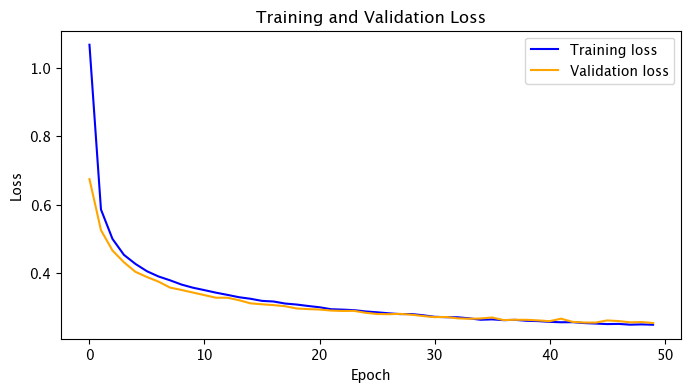

In [12]:
# Plot the training and validation loss
utils.plot_history(history["loss"], history["val_loss"], "Training and Validation Loss", "Epoch", "Loss")

### Model evaluation

In [13]:
# Predict the labels
predictions = model(X_test)

# Apply the argmax function to the predictions
predictions = np.argmax(predictions, axis=1)

Accuracy: 0.91


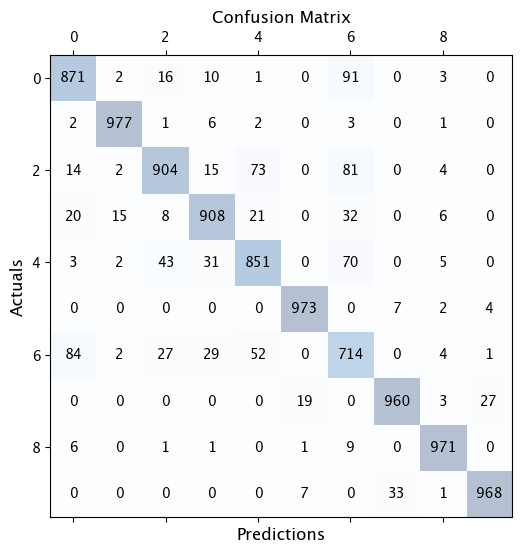

In [14]:
# Compute the accuracy
accuracy = metrics.accuracy(predictions, y_test)
confusion_matrix = metrics.confusion_matrix(num_classes, predictions, y_test)

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")

# Plot the confusion matrix
utils.plot_confusion_matrix(confusion_matrix)